In [2]:
import numpy as np
from cmocean import cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

# Data clean, save as new .csv file to mai_workspace

In [3]:
runhorse = True
if runhorse:

    tdir = '/gpfs/home/mep22dku/scratch/DATA/'
    glodap = pd.read_csv(f'{tdir}GLODAPv2.2021_Merged_Master_File.csv')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    #print(glodap.head())

    tDIC = np.array(glodap['G2tco2'][:])
    tco2f = np.array(glodap['G2tco2f'][:])
    tco2qc = np.array(glodap['G2tco2qc'][:])

    tALK = np.array(glodap['G2talk'][:])
    talkf = np.array(glodap['G2talkf'][:])
    tco2f = np.array(glodap['G2tco2f'][:])

    tSAL = np.array(glodap['G2salinity'][:])
    tTEMP = np.array(glodap['G2temperature'][:])
    tPRES = np.array(glodap['G2pressure'][:])
    tLAT = np.array(glodap['G2latitude'][:])
    tLON = np.array(glodap['G2longitude'][:])
    tYEAR = np.array(glodap['G2year'])
    tMONTH = np.array(glodap['G2month'])
    #tAOU = np.array(glodap['aou'][:])

    dens = seawater.dens(tSAL,tTEMP,tPRES)
    tDIC=tDIC*dens/1000
    tALK=tALK*dens/1000

    tALK_DIC = tALK-tDIC
    tALK_DIC2 = tALK-(tDIC+50)

    # tfilt = (tLAT <= -50) & (tco2f < 9) & (talkf <9) & ~np.isnan(tDIC) & ~np.isnan(tALK) 
    tfilt = (tco2f < 9) & (talkf <9) & ~np.isnan(tDIC) & ~np.isnan(tALK) 
    tDIC_SO = tDIC[tfilt]
    print(np.nanmin(tDIC_SO))
    tco2f_SO =  tco2f[tfilt]
    tco2qc_SO = tco2qc[tfilt]
    tALK_SO = tALK[tfilt]
    talkf_SO = talkf[tfilt]
    tco2f_SO = tco2f[tfilt]

    tSAL_SO = tSAL[tfilt]
    tTEMP_SO = tTEMP[tfilt]
    tPRES_SO = tPRES[tfilt]
    tLAT_SO = tLAT[tfilt]
    tLON_SO = tLON[tfilt]
    tYEAR_SO = tYEAR[tfilt]
    tMONTH_SO = tMONTH[tfilt]
    tSECT_SO = np.zeros_like(tLON_SO)
    tSECT_SO[(tLON_SO <= -67) | (tLON_SO > 150)] = 4 #pacific
    tSECT_SO[(tLON_SO <= 20) &(tLON_SO > -67)] = 2 #atl
    tSECT_SO[(tLON_SO > 20) &(tLON_SO <= 150)] = 3 #indian

    print(np.shape(tYEAR_SO))
    df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO]).T
    # df = df.sort_values(by = tYEAR_SO)
    df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT']
    # df.to_csv('/gpfs/home/gdg21vsa/mai_workspace/GLODAPv2.2021_GLOBE_valid_DICTA_umolL.csv')

-1463657274092.2107
(432073,)


In [4]:
df.to_csv('/gpfs/home/gdg21vsa/mai_workspace/GLODAPv2.2021_GLOBE_valid_DICTA_umolL.csv')

# Read new .csv file; Valid DIC and TA measurements in Global Ocean \n GLODAPv2.2021

In [6]:
df = pd.read_csv('/gpfs/home/gdg21vsa/mai_workspace/GLODAPv2.2021_GLOBE_valid_DICTA_umolL.csv')
df = df.sort_values(by = 'YR')

tDIC_SO = np.array(df['DIC'][:])
tALK_SO = np.array(df['ALK'][:])


tSAL_SO = np.array(df['SAL'][:])
tTEMP_SO = np.array(df['TEMP'][:])
tPRES_SO = np.array(df['PRES'][:])
tLAT_SO = np.array(df['LAT'][:])
tLON_SO = np.array(df['LON'][:])
tYEAR_SO = np.array(df['YR'])
tMONTH_SO = np.array(df['MONTH'])
tSECT_SO = np.array(df['SECT'])

# ? season

In [7]:
yrs = np.arange(1972,2021,1)
OBS_depths = np.zeros([5,len(yrs)])
OBS_seas = np.zeros([4,len(yrs)])
OBS_lats = np.zeros([6,len(yrs)])
OBS_sects = np.zeros([3,len(yrs)])

for i in range(0,len(yrs)):
    tyr = yrs[i]

    OBS_depths[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO<=200)])
    OBS_depths[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>200) & (tPRES_SO<=500)]) 
    OBS_depths[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>500) & (tPRES_SO<=1000)]) 
    OBS_depths[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>1000) & (tPRES_SO<=3000)]) 
    OBS_depths[4,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>3000)]) 
    
    #spring
    OBS_seas[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO<=11) & (tMONTH_SO>8)]) #spring
    OBS_seas[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tMONTH_SO==12) | (tMONTH_SO<=2))])  #sumer
    OBS_seas[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>2) & (tMONTH_SO<=5)]) #autum
    OBS_seas[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>5) & (tMONTH_SO<=8)]) #winter
    
    #sectors
#spring
    OBS_sects[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 2)]) #atl
    OBS_sects[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 3)])  #ind
    OBS_sects[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tSECT_SO == 4))]) #pac

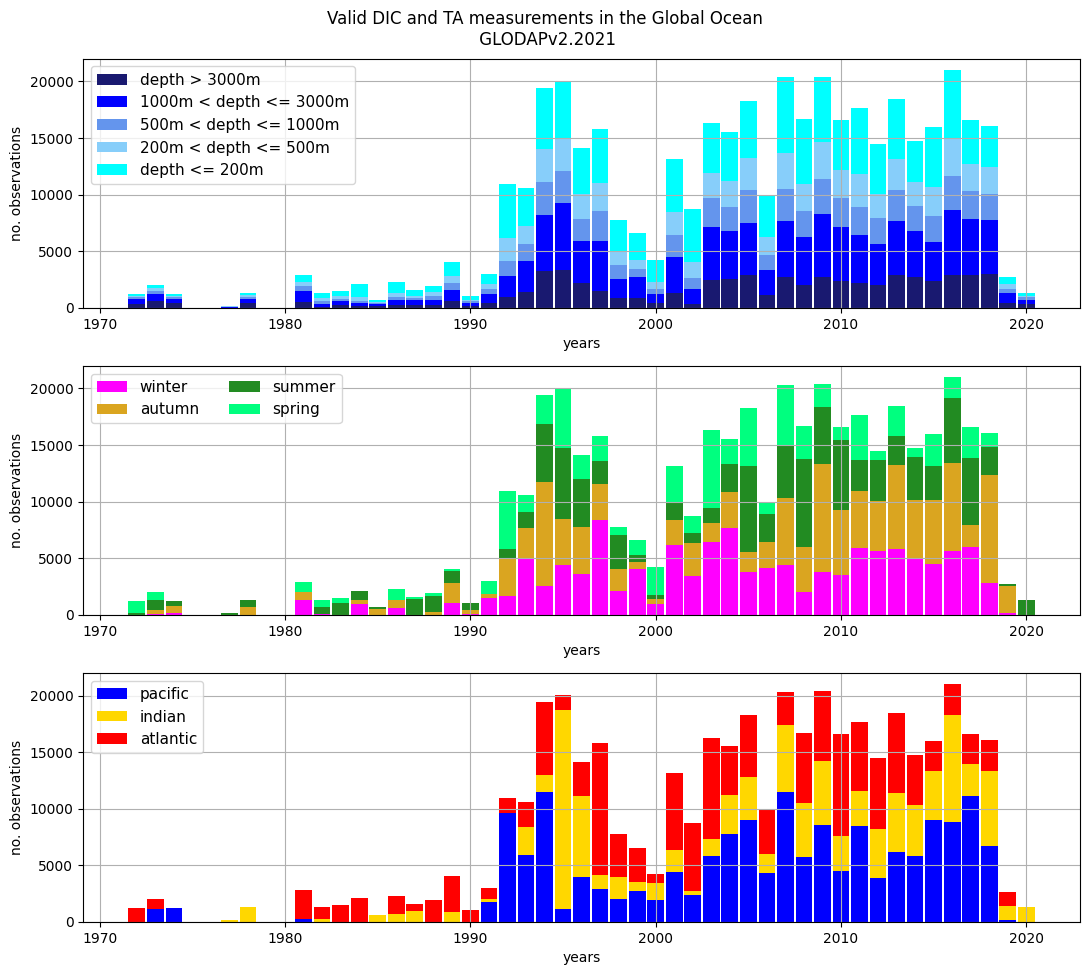

In [16]:
fact = 0.55
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 11
width = 0.9
axs[0].bar(yrs,OBS_depths[4,:],width, color = 'midnightblue', label = 'depth > 3000m')
axs[0].bar(yrs,OBS_depths[3,:],width, bottom = OBS_depths[4,:], color = 'b', label = '1000m < depth <= 3000m')
axs[0].bar(yrs,OBS_depths[2,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:], color = 'cornflowerblue', label = '500m < depth <= 1000m')
axs[0].bar(yrs,OBS_depths[1,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:], color = 'lightskyblue', label = '200m < depth <= 500m')
axs[0].bar(yrs,OBS_depths[0,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:]+OBS_depths[1,:], color = 'cyan', label = 'depth <= 200m')
axs[0].legend(ncol = 1, loc = 'best', fontsize = fs)

axs[1].bar(yrs,OBS_seas[3,:],width,  color = 'magenta', label = 'winter')
axs[1].bar(yrs,OBS_seas[2,:],width, bottom = OBS_seas[3,:], color = 'goldenrod', label = 'autumn')
axs[1].bar(yrs,OBS_seas[1,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:], color = 'forestgreen', label = 'summer')
axs[1].bar(yrs,OBS_seas[0,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:]+OBS_seas[1,:], color = 'springgreen', label = 'spring')
axs[1].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[2].bar(yrs,OBS_sects[2,:],width,  color = 'b', label = 'pacific')
axs[2].bar(yrs,OBS_sects[1,:],width, bottom = OBS_sects[2,:], color = 'gold', label = 'indian')
axs[2].bar(yrs,OBS_sects[0,:],width, bottom = OBS_sects[2,:]+OBS_sects[1,:], color = 'r', label = 'atlantic')
axs[2].legend(ncol = 1, loc = 'best', fontsize = fs)
# ax.bar(x, diat_means, width, yerr=men_std, label='diat',color = 'r', alpha = 0.8)
# ax.bar(x, flag_means, width, yerr=women_std, bottom=diat_means,
#        label='flag', color = 'r', hatch='.', alpha = 0.6)

for i in range(0,3):
    axs[i].set_ylim([0,22000])
    axs[i].grid()
    axs[i].set_xlabel('years'); axs[i].set_ylabel('no. observations')

plt.suptitle('Valid DIC and TA measurements in the Global Ocean\n GLODAPv2.2021')
plt.tight_layout()